# Librerias

In [1]:
import pandas as pd
import json
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import wordcloud
from nltk.probability import FreqDist
from funciones import get_sent_tokens,get_lemma,get_stems,remove_stop_words,get_word_tokens, remove_special_characters, tokenize_summary, filter_and_tokenize_words, get_word_counter, train_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from optuna.integration import OptunaSearchCV
from optuna.distributions import IntDistribution, CategoricalDistribution,LogUniformDistribution
from keras.preprocessing import sequence
from keras.layers import LSTM, Dense
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN



[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Alvaro\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Alvaro\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Alvaro\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
c:\Users\Alvaro\Desktop\BookGenreDetector\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Obtención y preprocesado de datos

In [2]:
data = pd.read_csv("../data/BooksDataSet.csv").drop(columns=['Unnamed: 0'])
data

,book_id,book_name,genre,summary
0,3248537,Drowned Wednesday,Fantasy,Drowned Wednesday is the first Trustee among ...
1,27796919,The Lost Hero,Fantasy,"As the book opens, Jason awakens on a school ..."
2,3910776,The Eyes of the Overworld,Fantasy,Cugel is easily persuaded by the merchant Fia...
3,5969644,Magic's Promise,Fantasy,The book opens with Herald-Mage Vanyel return...
4,3173445,Taran Wanderer,Fantasy,Taran and Gurgi have returned to Caer Dallben...
...,...,...,...,...
2995,10372180,White Death,Thriller,"A Novel from the NUMA files, A Kurt Austin Ad..."
2996,14504372,Venus with Pistol,Thriller,Gilbert Kemp is dealer specializing in antiqu...
2997,3617412,Blackwater,Thriller,"""How do you know when you're in too deep? Dav..."
2998,11320975,The Rainbow and the Rose,Thriller,The story concerns the life of Johnnie Pascoe...


In [3]:
data = data[["genre", "summary"]]
data

,genre,summary
0,Fantasy,Drowned Wednesday is the first Trustee among ...
1,Fantasy,"As the book opens, Jason awakens on a school ..."
2,Fantasy,Cugel is easily persuaded by the merchant Fia...
3,Fantasy,The book opens with Herald-Mage Vanyel return...
4,Fantasy,Taran and Gurgi have returned to Caer Dallben...
...,...,...
2995,Thriller,"A Novel from the NUMA files, A Kurt Austin Ad..."
2996,Thriller,Gilbert Kemp is dealer specializing in antiqu...
2997,Thriller,"""How do you know when you're in too deep? Dav..."
2998,Thriller,The story concerns the life of Johnnie Pascoe...


In [4]:
data.isnull().sum()

genre      0
summary    0
dtype: int64

In [5]:
data.genre.value_counts()

genre
Fantasy             500
Science Fiction     500
Crime Fiction       500
Historical novel    500
Horror              500
Thriller            500
Name: count, dtype: int64

In [6]:
data2 = pd.read_csv("../data/booksFiltered.csv").rename(columns={"genres":"genre"})
data2

,genre,summary
0,Children's literature,"Old Major, the old boar on the Manor Farm, ca..."
1,Speculative fiction,"Old Major, the old boar on the Manor Farm, ca..."
2,Fiction,"Old Major, the old boar on the Manor Farm, ca..."
3,Science Fiction,"Alex, a teenager living in near-future Englan..."
4,Novel,"Alex, a teenager living in near-future Englan..."
...,...,...
27500,Thriller,The series follows the character of Nick Ston...
27501,Thriller,The reader first meets Rapp while he is doing...
27502,Fiction,The reader first meets Rapp while he is doing...
27503,Novel,Makar Devushkin and Varvara Dobroselova are s...


In [11]:
data_cc = pd.concat([data, data2]).reset_index(drop=True)
data_cc

,genre,summary
0,Fantasy,Drowned Wednesday is the first Trustee among ...
1,Fantasy,"As the book opens, Jason awakens on a school ..."
2,Fantasy,Cugel is easily persuaded by the merchant Fia...
3,Fantasy,The book opens with Herald-Mage Vanyel return...
4,Fantasy,Taran and Gurgi have returned to Caer Dallben...
...,...,...
30500,Thriller,The series follows the character of Nick Ston...
30501,Thriller,The reader first meets Rapp while he is doing...
30502,Fiction,The reader first meets Rapp while he is doing...
30503,Novel,Makar Devushkin and Varvara Dobroselova are s...


In [12]:
def summary_processing(row):
    summary = row["summary"]
    get_stems(summary)
    

In [13]:
data_cc.summary[0]

' Drowned Wednesday is the first Trustee among the Morrow Days who is on Arthur\'s side and wishes the Will to be fulfilled. She appears as a leviathan/whale and suffers from Gluttony. The book begins when Leaf is visiting Arthur and they are discussing the invitation that Drowned Wednesday sent him. Arthur had been admitted to hospital because of the damage done to his leg when he attempted to enter Tuesday\'s Treasure Tower. Suddenly, the hospital room becomes flooded with water as the two are transported to the Border Sea of the House. Leaf is snatched away by a large ship with green sails, known as the Flying Mantis, while Arthur remains in his bed. When the Medallion given him by the immortal called the Mariner apparently fails to summon help, Arthur is without hope. Eventually, a buoy marking the pirate Elishar Feverfew\'s treasure floats toward him. As soon as Arthur opens it, his hand is marked with a bloody red colour. Arthur now has the Red Hand, by which Feverfew marks whoev

In [15]:
a = data_cc.summary[0]
#tokenizacion de frases
sentences = get_sent_tokens(a)
#quitamos caracteres especiales
clean = remove_special_characters(sentences)
#tokenizacion de palabras
words = get_word_tokens(clean)
#stemming
stems = get_stems(words)
#lemmatization
lemma = get_lemma(stems)
#quitamos stopwords
pre = remove_stop_words(lemma)
pre

['drown',
 'wednesday',
 'first',
 'truste',
 'among',
 'morrow',
 'day',
 'arthur',
 'side',
 'wish',
 'fulfil',
 'appear',
 'leviathanwhal',
 'suffer',
 'gluttoni',
 'book',
 'begin',
 'leaf',
 'visit',
 'arthur',
 'discus',
 'invit',
 'drown',
 'wednesday',
 'sent',
 'arthur',
 'admit',
 'hospit',
 'becaus',
 'damag',
 'done',
 'hi',
 'leg',
 'attempt',
 'enter',
 'tuesday',
 'treasur',
 'tower',
 'suddenli',
 'hospit',
 'room',
 'becom',
 'flood',
 'water',
 'two',
 'transport',
 'border',
 'sea',
 'hous',
 'leaf',
 'snatch',
 'away',
 'larg',
 'ship',
 'green',
 'sail',
 'known',
 'fli',
 'manti',
 'arthur',
 'remain',
 'hi',
 'bed',
 'medallion',
 'given',
 'immort',
 'call',
 'marin',
 'appar',
 'fail',
 'summon',
 'help',
 'arthur',
 'without',
 'hope',
 'eventu',
 'buoy',
 'mark',
 'pirat',
 'elishar',
 'feverfew',
 'treasur',
 'float',
 'toward',
 'soon',
 'arthur',
 'open',
 'hi',
 'hand',
 'mark',
 'bloodi',
 'red',
 'colour',
 'arthur',
 'ha',
 'red',
 'hand',
 'feverfew',

In [16]:
def process_summary(summary):
    #tokenizacion de frases
    sentences = get_sent_tokens(summary)
    #quitamos caracteres especiales
    clean = remove_special_characters(sentences)
    #tokenizacion de palabras
    words = get_word_tokens(clean)
    #stemming
    stems = get_stems(words)
    #lemmatization
    lemma = get_lemma(stems)
    #quitamos stopwords
    pre = remove_stop_words(lemma)
    return ' '.join(pre)

data_cc['summary'] = data_cc['summary'].apply(lambda x: process_summary(x))

In [21]:
#checkpoint 1
import pickle 

with open("data_ch1.pkl", "wb") as f:
    pickle.dump(data_cc, f)

In [1]:
import pickle
with open("data_ch1.pkl", "rb") as f:
    data_cc = pickle.load(f)

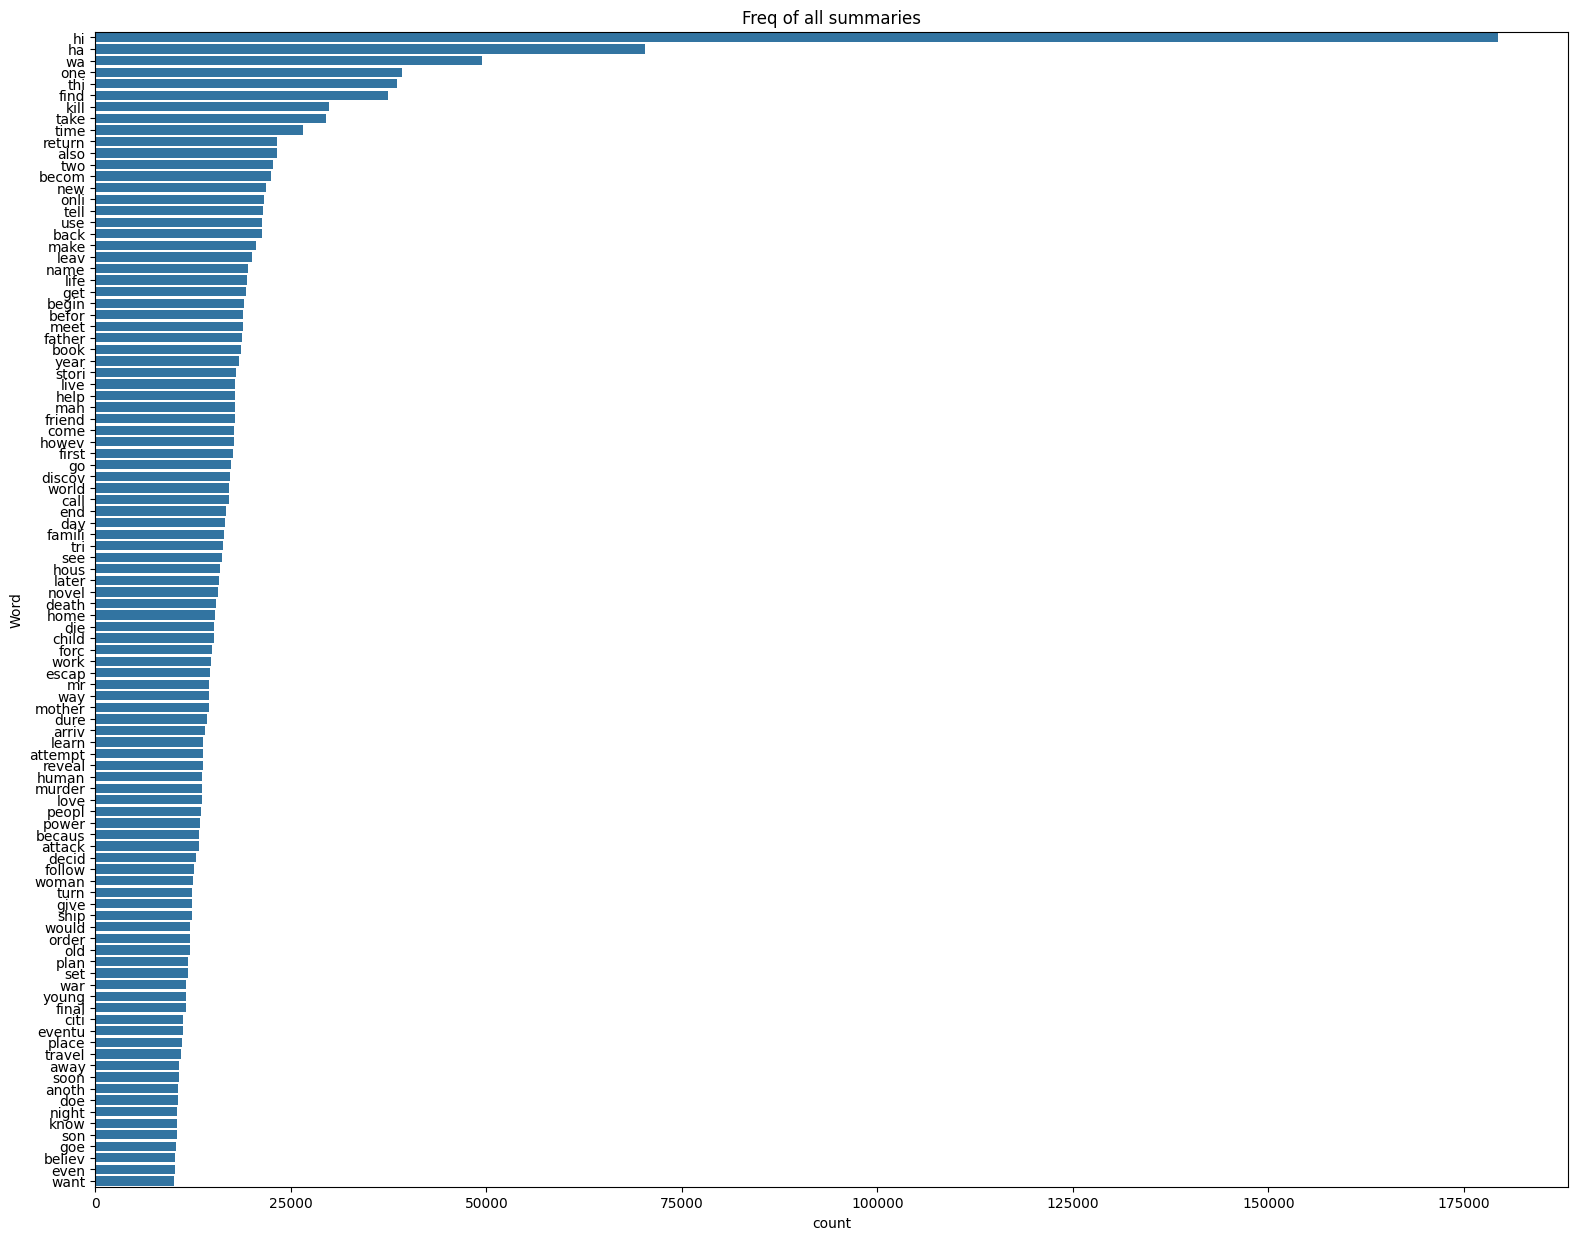

<module 'matplotlib.pyplot' from 'c:\\Users\\Alvaro\\Desktop\\BookGenreDetector\\venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

In [21]:

#mostramos las 100 palabras mas comunes entre todos los libros
def plot_most_frequent_words(words, num_words=100, title=None, plt_show=None, size=(19,15)):
    # Create a frequency distribution of the words
    freq_dist = FreqDist(words)
    
    # Select the top 'num_words' most frequent words
    wordsdf = pd.DataFrame({'word':list(freq_dist.keys()), 'count':list(freq_dist.values())}) 
    top_words = wordsdf.sort_values(by='count', ascending=False).iloc[0:num_words]
    
    # Plotting
    plt.figure(figsize=size) 
    if title:
        plt.title(title)
    ax = sns.barplot(data=top_words, x= "count", y = "word") 
    ax.set(ylabel = 'Word') 
    if plt_show:
        plt.show()
    return plt
    
plot_most_frequent_words(' '.join(list(data_cc.summary)).split(' '), num_words=100, title="Freq of all summaries", plt_show=True)

In [ ]:
data_cc.groupby('genre')

C:\Users\Alvaro\AppData\Local\Temp\ipykernel_23636\2737546383.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  plts = data_cc.groupby('genre').apply(lambda x: plot_most_frequent_words(' '.join(list(x.summary)).split(' '), num_words=20, title=x.name, plt_show=False, size=(5,7)))


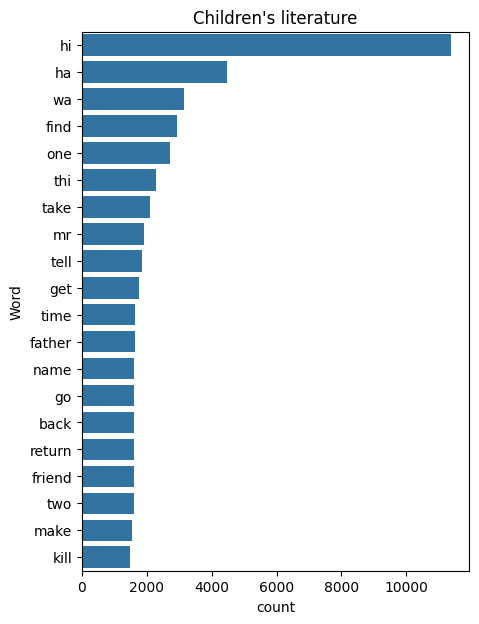

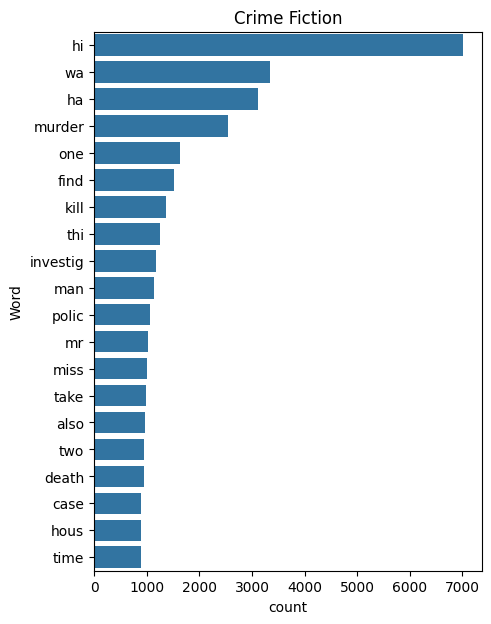

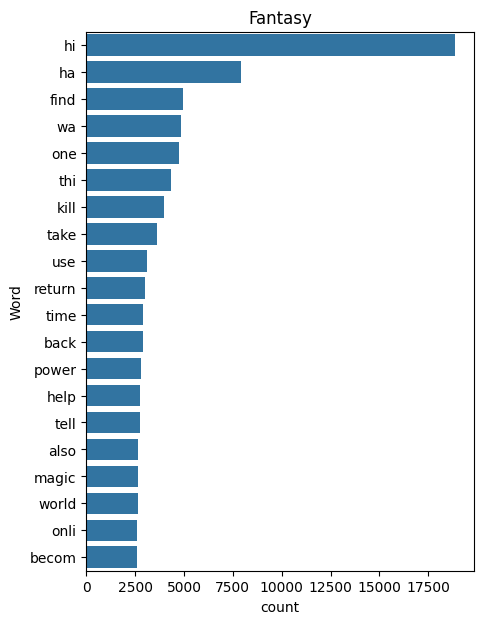

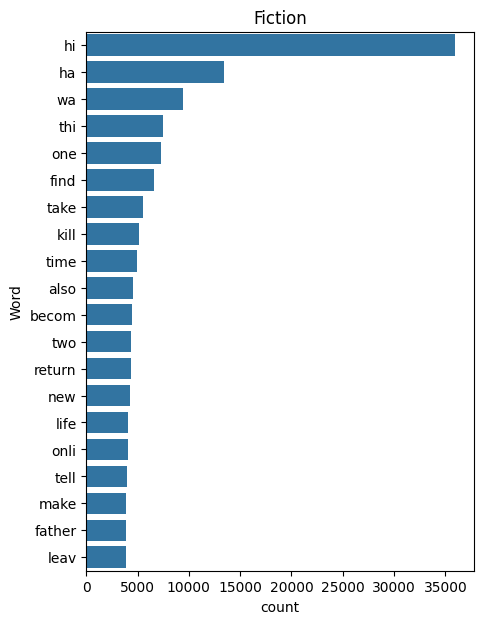

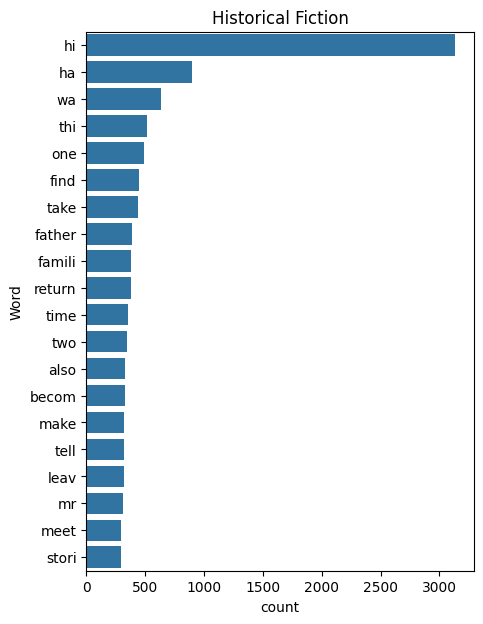

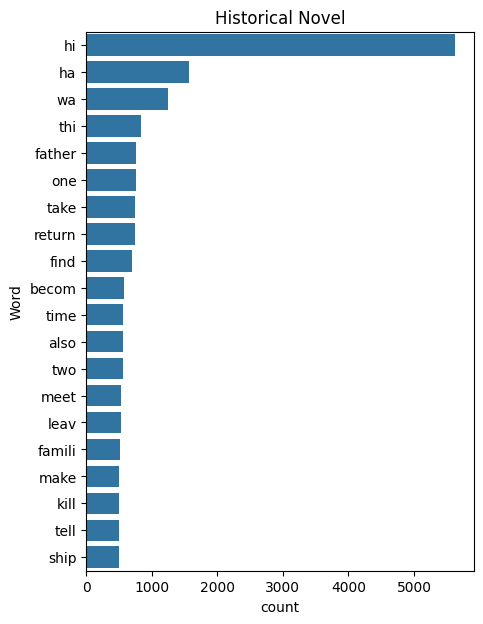

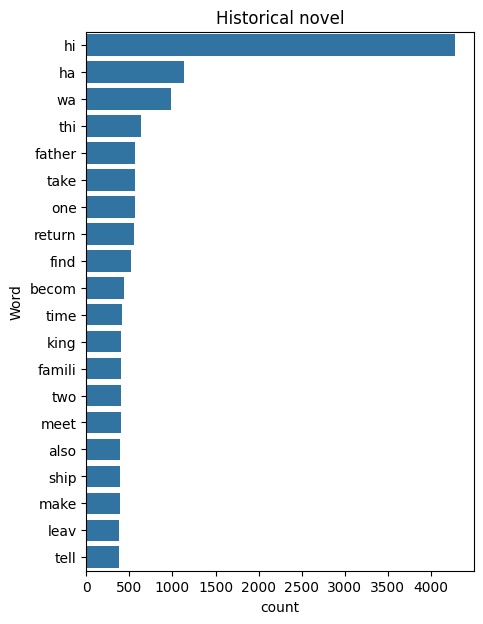

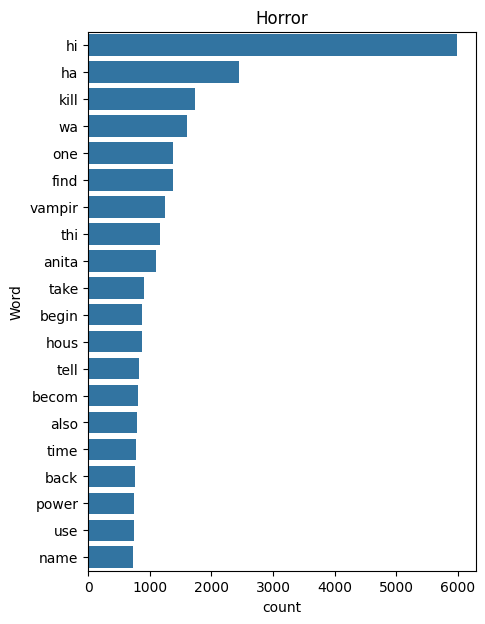

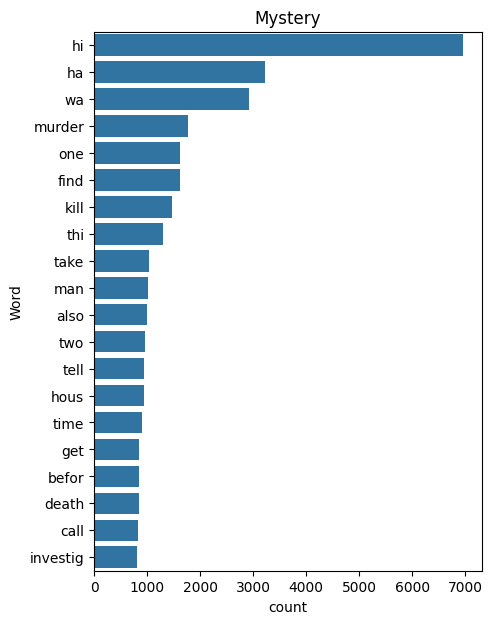

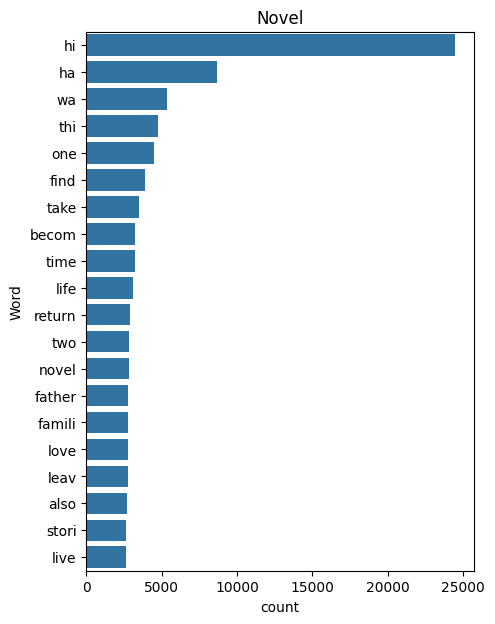

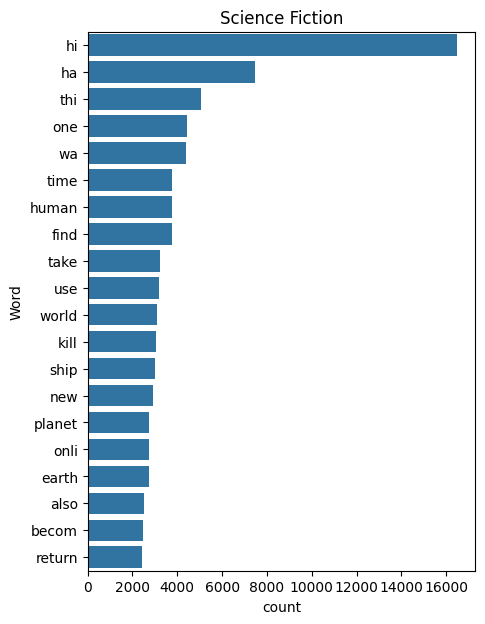

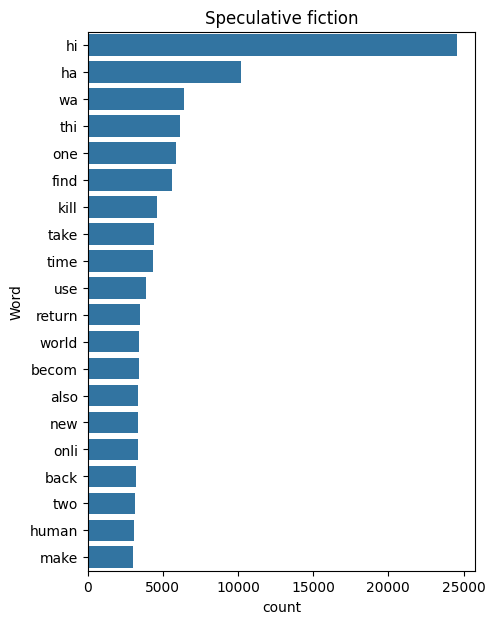

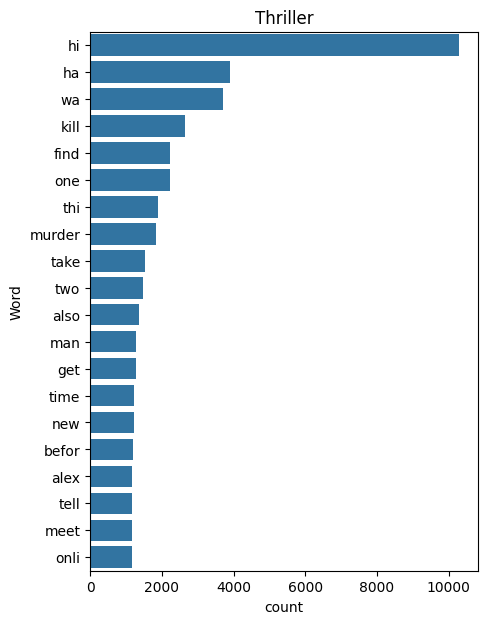

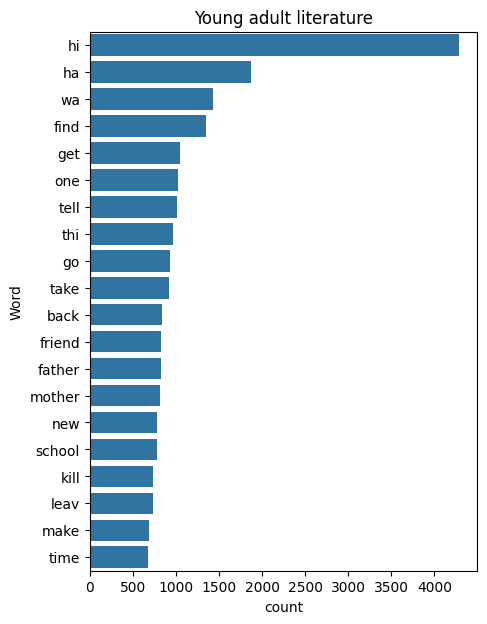

In [23]:
plts = data_cc.groupby('genre').apply(lambda x: plot_most_frequent_words(' '.join(list(x.summary)).split(' '), num_words=20, title=x.name, plt_show=False, size=(5,7)))

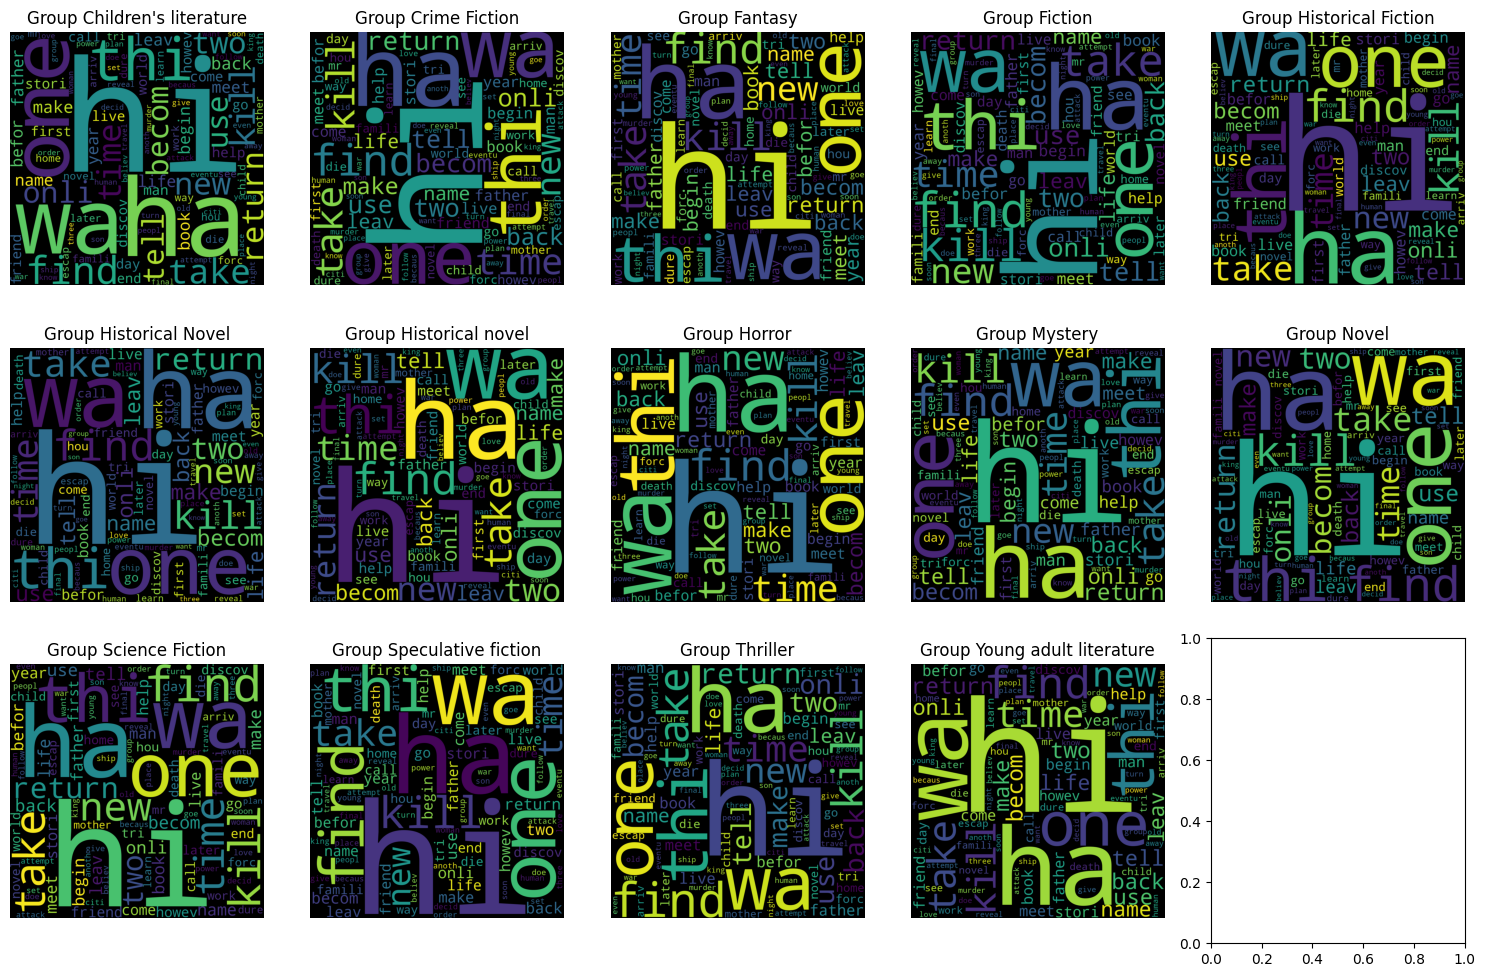

In [20]:
fig, axes = plt.subplots(3, 5, figsize=(15, 10))

for (genre,grp),ax in zip(data_cc.groupby('genre'),axes.flatten()):
    wc = wordcloud.WordCloud(
        width=1000, 
        height=1000, 
        max_words=100,
        collocations=False
    ).generate(text=(' '.join(data_cc.summary)))
    ax.imshow(wc)
    ax.set_title(f'Group {genre}')
    ax.axis("off");    

# Adjust layout
plt.tight_layout()
plt.show()
    

# Features

In [2]:
import pickle
with open("data_ch1.pkl", "rb") as f:
    data_cc = pickle.load(f)

In [3]:
#usamos label encoder para codificar cada género
LE = LabelEncoder()
y=LE.fit_transform(data_cc['genre'])
dict(zip(LE.classes_,LE.transform(LE.classes_)))

{"Children's literature": 0,
 'Crime Fiction': 1,
 'Fantasy': 2,
 'Fiction': 3,
 'Historical Fiction': 4,
 'Historical Novel': 5,
 'Historical novel': 6,
 'Horror': 7,
 'Mystery': 8,
 'Novel': 9,
 'Science Fiction': 10,
 'Speculative fiction': 11,
 'Thriller': 12,
 'Young adult literature': 13}

In [4]:
X_train, X_test, y_train, y_test = train_test_split(data_cc['summary'], y, test_size=0.2, random_state=557) 

In [5]:
#aplicamos tf-idf para poder pasarlo a los modelos
# Initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer() # se ha visto que funciona mejor sin limtar el max_df ni el max_features

# Fit and transform the documents
tf_train  = tfidf_vectorizer.fit_transform(X_train)

# Convert the TF-IDF matrix to a pandas DataFrame
tf_test = tfidf_vectorizer.transform(X_test)



In [6]:
def apply_tfidf(string):
    tfidf_vectorizer = TfidfVectorizer() # se ha visto que funciona mejor sin limtar el max_df ni el max_features
    # Fit and transform the documents
    tf_train  = tfidf_vectorizer.fit_transform(X_train)
    # Convert the TF-IDF matrix to a pandas DataFrame
    tf_test = tfidf_vectorizer.transform(string)
    return tf_test
    

# Modelos

## Random Forest

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 300, 500, 1000],
    'max_depth': [10,20,None],
    'min_samples_split':[2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto','sqrt']
}
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=1,
    max_features='sqrt'
)

rf.fit(tf_train, y_train)

# random = RandomizedSearchCV(
#     estimator=rf,
#     param_distributions=param_grid,
#     n_iter=1,
#     cv=5,
#     n_jobs=-1,
#     verbose=True
# )
# # fit model on train data.
# random.fit(tf_train, y_train)

# print("Best parameters found: ", random.best_params_)
# print("Best score found: ", random.best_score_)
# rf = random.best_estimator_

KeyboardInterrupt: 

In [ ]:
#guardamos los resultados para poder recuperarlo sin ejecutar todo
import pickle
with open("rfv2.pkl", 'wb') as f:
    pickle.dump(optuna, f)

In [16]:
import pickle
with open("rf.pkl", 'rb') as f:
    optuna = pickle.load(f)

In [17]:
optuna

OptunaSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1, n_trials=40,
               param_distributions={'max_depth': IntDistribution(high=31, log=False, low=1, step=5),
                                    'max_features': CategoricalDistribution(choices=('auto', 'sqrt', 0.9, 0.75)),
                                    'min_samples_leaf': IntDistribution(high=30, log=5, low=1, step=1),
                                    'min_samples_split': IntDistribution(high=30, log=5, low=1, step=1),
                                    'n_estimators': IntDistribution(high=500, log=False, low=100, step=50)},
               random_state=99, timeout=600, verbose=False)

In [ ]:
rf = optuna.best_estimator_

In [8]:
# make predictions for validation set.
y_pred = rf.predict(tf_test)

#Calculating the accuracy.
print( 'Accuracy Score :',accuracy_score(y_test,y_pred) )

#Printing the classification report.
print ('Report : ')
print(classification_report(y_test,y_pred))

Accuracy Score : 0.1812817570890018
Report : 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       405
           1       0.00      0.00      0.00       313
           2       0.23      0.03      0.05       633
           3       0.18      0.92      0.30      1083
           4       0.00      0.00      0.00        69
           5       0.00      0.00      0.00       129
           6       0.00      0.00      0.00        87
           7       0.00      0.00      0.00       191
           8       0.00      0.00      0.00       293
           9       0.00      0.00      0.00       759
          10       0.34      0.12      0.18       704
          11       0.05      0.01      0.02       877
          12       0.00      0.00      0.00       397
          13       0.00      0.00      0.00       161

    accuracy                           0.18      6101
   macro avg       0.06      0.08      0.04      6101
weighted avg       0.10      0.18 

c:\Users\Alvaro\Desktop\BookGenreDetector\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Alvaro\Desktop\BookGenreDetector\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Alvaro\Desktop\BookGenreDetector\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

## Logistic Regression

In [ ]:
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)

# fit model on train data.
clf.fit(tf_train, y_train)

# make predictions for validation set.
y_pred_lr = clf.predict(tf_test)

#Calculating the accuracy.
print( 'Accuracy Score :',accuracy_score(y_test,y_pred_lr))

#Printing the classification report.
print ('Report : ')
print(classification_report(y_test,y_pred_lr))
#.7916666666

Accuracy Score : 0.7916666666666666
Report : 
              precision    recall  f1-score   support

           0       0.79      0.82      0.81       102
           1       0.73      0.79      0.76        89
           2       0.82      0.88      0.85       110
           3       0.79      0.76      0.78       100
           4       0.83      0.78      0.80        97
           5       0.78      0.71      0.74       102

    accuracy                           0.79       600
   macro avg       0.79      0.79      0.79       600
weighted avg       0.79      0.79      0.79       600



In [ ]:
tf_test

<600x35870 sparse matrix of type '<class 'numpy.float64'>'
	with 93588 stored elements in Compressed Sparse Row format>

In [ ]:
import numpy as np
print(clf.predict(apply_tfidf(["space time is flexible when dealing with aliens in space"]))) #tiene sentido que sea ciencia ficción
print(clf.predict(apply_tfidf(["The detective wasn't sure if the crime would be solvable"]))) #tiene sentido que sea crimen

[4]
[0]


## SVM

In [ ]:
from sklearn.svm import SVC

from optuna.integration import OptunaSearchCV
from optuna.distributions import IntDistribution, CategoricalDistribution,FloatDistribution

param_grid = {
    "C": CategoricalDistribution([.1, 1, 10, 100, 1000]),
    "kernel": CategoricalDistribution(['linear', 'poly', 'rbf', 'sigmoid']),
    "degree": IntDistribution(0, 5),
    "gamma": CategoricalDistribution(["auto","scale"]),
    "shrinking": CategoricalDistribution([True, False]),
    "probability": CategoricalDistribution([True, False])
}
svc = SVC()

rs = OptunaSearchCV(
    estimator=svc,
    param_distributions=param_grid,
    n_trials=50,
    timeout=15*60,
    cv=5,
    random_state=99,
    n_jobs=-1,
    verbose=False
)
# fit model on train data.
rs.fit(tf_train, y_train)


In [24]:
# len(rs.trials_)

In [ ]:
# guardamos los resultados para poder recuperarlo sin ejecutar todo
import pickle
with open("svcv2.pkl", 'wb') as f:
    pickle.dump(rs, f)

In [26]:
import pickle
with open("svc.pkl", 'rb') as f:
    rs = pickle.load(f)

In [27]:
print("Best parameters found: ", rs.best_params_)
print("Best score found: ", rs.best_score_)
svc = rs.best_estimator_


Best parameters found:  {'C': 1, 'kernel': 'sigmoid', 'degree': 2, 'gamma': 'scale', 'shrinking': False, 'probability': False}
Best score found:  0.7095833333333333


In [28]:
# make predictions for validation set.
y_pred = svc.predict(tf_test)

#Calculating the accuracy.
print( 'Accuracy Score :',accuracy_score(y_test,y_pred) )

#Printing the classification report.
print ('Report : ')
print(classification_report(y_test,y_pred))

Accuracy Score : 0.7783333333333333
Report : 
              precision    recall  f1-score   support

           0       0.82      0.77      0.80       102
           1       0.71      0.75      0.73        89
           2       0.81      0.86      0.84       110
           3       0.77      0.75      0.76       100
           4       0.83      0.79      0.81        97
           5       0.73      0.73      0.73       102

    accuracy                           0.78       600
   macro avg       0.78      0.78      0.78       600
weighted avg       0.78      0.78      0.78       600



## RNNs

### Bag of words

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
#Count vectorizer for bag of words
cv=CountVectorizer(min_df=0.0,max_df=1.0,binary=False,ngram_range=(1,3))
#transformed train reviews
cv_train_reviews=cv.fit_transform(X_train)
#transformed test reviews
cv_test_reviews=cv.transform(X_test)

print('BOW_cv_train:',cv_train_reviews.shape)
print('BOW_cv_test:',cv_test_reviews.shape)
#vocab=cv.get_feature_names()-toget feature names

BOW_cv_train: (2400, 1142068)
BOW_cv_test: (600, 1142068)


### Preprocessing for adecuate input

In [30]:
df_lstm = data[['genre','summary']]
df_lstm

,genre,summary
0,Fantasy,drown wednesday first truste among morrow day ...
1,Fantasy,book open jason awaken school bu unabl rememb ...
2,Fantasy,cugel easili persuad merchant fianosth attempt...
3,Fantasy,book open heraldmag vanyel return hi countri v...
4,Fantasy,taran gurgi return caer dallben follow event t...
...,...,...
2995,Thriller,novel numa file kurt austin adventur thi novel...
2996,Thriller,gilbert kemp dealer special antiqu gun london ...
2997,Thriller,know deep davey ha alway live shadow hi older ...
2998,Thriller,stori concern life johnni pasco retir commerci...


In [31]:
summ_lengths = [len(get_word_tokens(get_sent_tokens(elem))) for elem in df_lstm.summary]

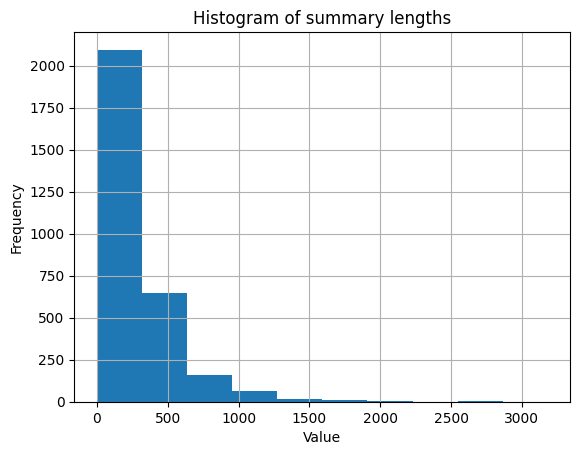

In [32]:
import matplotlib.pyplot as plt
# Plot histogram
plt.hist(summ_lengths)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of summary lengths')
plt.grid(True)
plt.show()


In [33]:
max([len(get_word_tokens(get_sent_tokens(elem))) for elem in df_lstm.summary])

3183

### LabelEncoder

### Frequency counting (like imbd dataset)

In [34]:
df_lstm = data[['genre','summary']]
df_lstm

,genre,summary
0,Fantasy,drown wednesday first truste among morrow day ...
1,Fantasy,book open jason awaken school bu unabl rememb ...
2,Fantasy,cugel easili persuad merchant fianosth attempt...
3,Fantasy,book open heraldmag vanyel return hi countri v...
4,Fantasy,taran gurgi return caer dallben follow event t...
...,...,...
2995,Thriller,novel numa file kurt austin adventur thi novel...
2996,Thriller,gilbert kemp dealer special antiqu gun london ...
2997,Thriller,know deep davey ha alway live shadow hi older ...
2998,Thriller,stori concern life johnni pasco retir commerci...


In [35]:
max_features = 10000
wc = get_word_counter(df_lstm.summary, max_features=max_features)
wc

{'hi': 17461,
 'ha': 6531,
 'wa': 5131,
 'one': 3764,
 'find': 3533,
 'thi': 3447,
 'kill': 3369,
 'take': 2733,
 'time': 2458,
 'two': 2194,
 'also': 2177,
 'return': 2154,
 'use': 2024,
 'tell': 2022,
 'becom': 1974,
 'back': 1970,
 'onli': 1967,
 'new': 1931,
 'befor': 1929,
 'make': 1881,
 'leav': 1857,
 'name': 1843,
 'begin': 1831,
 'meet': 1816,
 'murder': 1807,
 'man': 1787,
 'help': 1738,
 'year': 1737,
 'father': 1732,
 'book': 1696,
 'life': 1695,
 'discov': 1693,
 'get': 1676,
 'stori': 1650,
 'howev': 1640,
 'first': 1634,
 'come': 1626,
 'friend': 1621,
 'call': 1598,
 'tri': 1579,
 'hous': 1556,
 'go': 1542,
 'death': 1541,
 'see': 1534,
 'day': 1523,
 'live': 1506,
 'end': 1498,
 'later': 1496,
 'novel': 1471,
 'die': 1470,
 'world': 1465,
 'escap': 1456,
 'dure': 1425,
 'forc': 1425,
 'arriv': 1413,
 'attempt': 1371,
 'way': 1371,
 'power': 1368,
 'famili': 1364,
 'reveal': 1354,
 'home': 1344,
 'work': 1337,
 'ship': 1332,
 'attack': 1319,
 'learn': 1290,
 'human': 12

In [36]:
len(wc)

10000

In [37]:
df_lstm['summary'] = df_lstm.summary.apply(tokenize_summary)

C:\Users\Alvaro\AppData\Local\Temp\ipykernel_2784\2056286424.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lstm['summary'] = df_lstm.summary.apply(tokenize_summary)


In [38]:
df_lstm['summary'] = df_lstm.summary.apply(lambda row: filter_and_tokenize_words(row, wc))

C:\Users\Alvaro\AppData\Local\Temp\ipykernel_2784\1951547449.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lstm['summary'] = df_lstm.summary.apply(lambda row: filter_and_tokenize_words(row, wc))


In [39]:
df_lstm

,genre,summary
0,Fantasy,"[154, 24, 1634, 11, 296, 1523, 433, 336, 281, ..."
1,Fantasy,"[1696, 591, 142, 134, 495, 37, 282, 206, 209, ..."
2,Fantasy,"[10, 88, 192, 115, 1371, 10, 1787, 63, 110, 37..."
3,Fantasy,"[1696, 591, 60, 2154, 17461, 371, 17, 53, 112,..."
4,Fantasy,"[49, 13, 2154, 8, 10, 1215, 687, 246, 36, 263,..."
...,...,...
2995,Thriller,"[1471, 9, 66, 20, 30, 236, 3447, 1471, 339, 63..."
2996,Thriller,"[49, 18, 59, 227, 27, 272, 546, 89, 15, 65, 26..."
2997,Thriller,"[1001, 146, 6531, 171, 1506, 159, 17461, 176, ..."
2998,Thriller,"[1650, 243, 1695, 112, 15, 147, 12, 303, 125, ..."


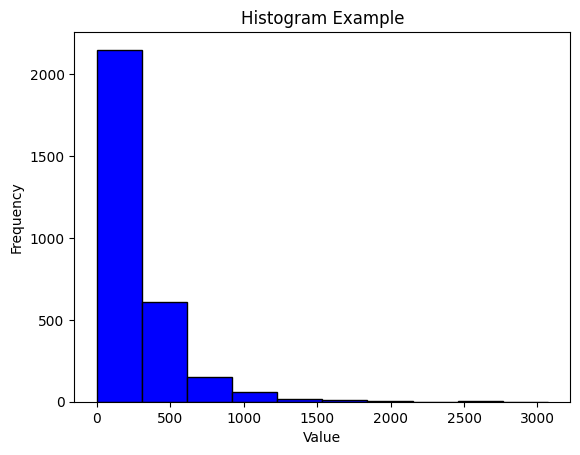

In [40]:
lengths = [len(e) for e in df_lstm.summary]

import matplotlib.pyplot as plt

# Sample data

# Plotting the histogram
plt.hist(lengths, color='blue', edgecolor='black')

# Adding labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram Example')

# Displaying the plot
plt.show()

In [41]:
print(len(y))
print(len(df_lstm.summary))

3000
3000


In [42]:
maxlen = 750
X_train = df_lstm.summary
y_train = y 
X_train = sequence.pad_sequences(X_train, maxlen=maxlen)

In [44]:
model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Epoch 1/10


75/75 ━━━━━━━━━━━━━━━━━━━━ 14s 165ms/step - acc: 0.2022 - loss: -2.2678 - val_acc: 0.0000e+00 - val_loss: -26.6464
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 162ms/step - acc: 0.2116 - loss: -7.9327 - val_acc: 0.0000e+00 - val_loss: -37.8396
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 169ms/step - acc: 0.2075 - loss: -10.4054 - val_acc: 0.0000e+00 - val_loss: -47.1151
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 175ms/step - acc: 0.2073 - loss: -12.8291 - val_acc: 0.0000e+00 - val_loss: -55.7870
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 162ms/step - acc: 0.2130 - loss: -15.4197 - val_acc: 0.0000e+00 - val_loss: -64.6405
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 162ms/step - acc: 0.2059 - loss: -16.6705 - val_acc: 0.0000e+00 - val_loss: -73.4222
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 163ms/step - acc: 0.1944 - loss: -20.4688 - val_acc: 0.0000e+00 - val_loss: -81.9521
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 177ms/step - acc: 0.2154 - loss: -21.1050 - val_acc: 0.0000e+00 - val_loss: -90.82

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (32, 750, 32)          │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (32, 32)               │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 1)                │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 656,708 (2.51 MB)

 Trainable params: 328,353 (1.25 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 328,355 (1.25 MB)

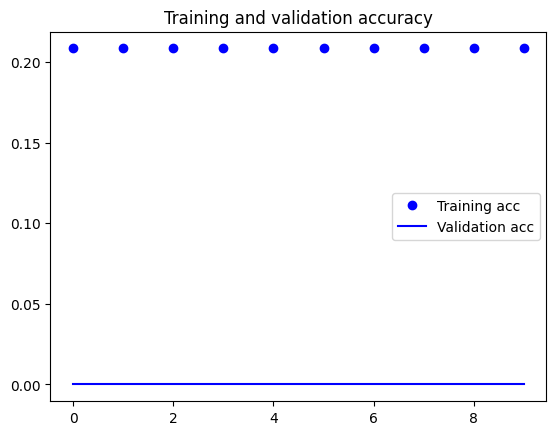

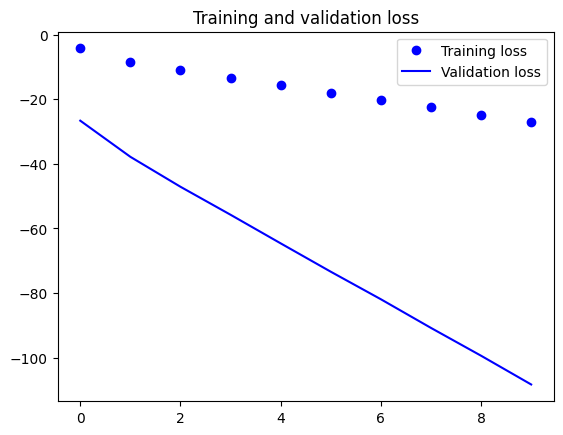

In [47]:
model.summary()
# from keras.utils import plot_model
# plot_model(model, show_shapes=True, to_file="model.png")
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()